# Loading packages and libraries

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
from numpy.random import seed
import numpy as np
import math

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import sklearn

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.callbacks import EarlyStopping
from tensorflow import keras
import tensorflow

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels
import statistics as st
import time

# Exploratory Data Analysis

In [22]:
# loading the data as a pandas dataframe and using the date column as the index
df = pd.read_csv("HT_DATA_Log_Transformed.csv", index_col=0)

#converting the date index column into Pandas Date format
df.index = pd.to_datetime(df.index)

In [23]:
#checks
print(df.tail())
print(df.describe())

# check for missing values
print(df.isnull().sum())

# checking the data types of each variable in the dataset
print(df.dtypes)

                 BTC  BTC_Yest      AUD        CAD       CHF       CNY  \
Date                                                                     
2020-12-08  0.017049  0.015169 -0.001787  0.003264 -0.001855  0.002225   
2020-08-13 -0.001296  0.017049  0.002746  0.005039  0.005894  0.001312   
2020-08-14  0.008194 -0.001296 -0.002247  0.001814  0.002372 -0.001062   
2020-08-15  0.002282  0.008194  0.000000  0.000000  0.000000  0.000000   
2020-08-16  0.029952  0.002282  0.000000  0.000000  0.000000  0.000000   

                 EUR       GBP       JPY       NZD  ...      N225       HSI  \
Date                                                ...                       
2020-12-08 -0.000106 -0.002025 -0.004994 -0.003659  ... -0.000883  0.014104   
2020-08-13  0.004867 -0.000208 -0.002880  0.001077  ...  0.014721 -0.000668   
2020-08-14  0.001928  0.001724 -0.001497 -0.004448  ...  0.000212 -0.001713   
2020-08-15  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08

## Creating X and Y dataframes 

In [24]:
# extracting the relevant columns for X (inputs) and Y(output) and converting them to numpy arrays
X = df.drop(columns=['BTC', 'BTC_Yest']).values
Y = df[['BTC']].values

In [25]:
#checks
print(rf" Shape of X: {X.shape}")
print(rf" Shape of Y: {Y.shape}")

 Shape of X: (2159, 32)
 Shape of Y: (2159, 1)


## Standardizing the data

In [26]:
from sklearn import preprocessing
X = preprocessing.scale(X)
# standardization to mean=0, variance=1

## Train-Test Split

In [27]:
# finding n to separate the data into the first 70% and next 30%
n_train = round(2159/10*7)
n_test = round(2159/10*3)
print(rf'The length of the training set is {n_train}')
print(rf'The length of the testing set is {n_test}')

The length of the training set is 1511
The length of the testing set is 648


In [28]:
# separating the data using train and test
X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]


In [29]:
#checks
print(rf" Shape of X_train: {X_train.shape}")
print(rf" Shape of Y_train: {Y_train.shape}")
print(rf" Shape of X_test:  {X_test.shape}")
print(rf" Shape of Y_test:  {Y_test.shape}")

 Shape of X_train: (1511, 32)
 Shape of Y_train: (1511, 1)
 Shape of X_test:  (648, 32)
 Shape of Y_test:  (648, 1)


# Feature Selection

(1511, 32)
Feature  AUD : 0.000000
Feature CAD: 0.000000
Feature CHF: 0.019290
Feature CNY: 0.000000
Feature EUR: 0.000000
Feature GBP: 0.000000
Feature JPY: 0.014366
Feature NZD: 0.000000
Feature KRW: 0.000000
Feature RON: 0.000000
Feature HKD: 0.007855
Feature SGD: 0.000000
Feature CL: 0.000000
Feature GC: 0.000000
Feature HG: 0.000000
Feature NG: 0.000000
Feature SI: 0.021587
Feature WTI: 0.000000
Feature DJI: 0.000000
Feature GSPC: 0.000000
Feature IXIC: 0.000000
Feature VIX: 0.000000
Feature N225: 0.000000
Feature HSI: 0.000000
Feature GDAXI: 0.001319
Feature KOSPI: 0.000000
Feature SSE: 0.000000
Feature FTSE100: 0.000000
Feature DXY: 0.000000
Feature US10Y: 0.000000
Feature LIBOR: 0.000000
Feature BTC_Vol: 0.000000


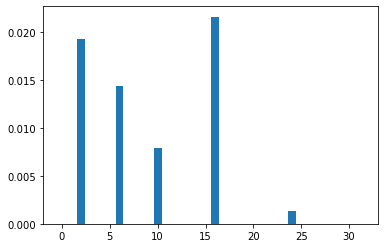

In [92]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

#fixing the random state to generate reproducible results
seed(6)


# define feature selection
fs = SelectKBest(score_func=mutual_info_regression, k='all')

# apply feature selection
X_selected = fs.fit_transform(X_train, Y_train.ravel())

print(X_selected.shape)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (df.drop(columns=['BTC','BTC_Yest']).columns.values[i], fs.scores_[i]))
#plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()



In [93]:
#chosing the featues with MIR>0
chosenfeatures = sum(fs.scores_>0)
print(rf'The number of features having a score>=0 are {chosenfeatures}')

# creating a new model with the chosen features
fs_chosen = SelectKBest(score_func=mutual_info_regression, k=chosenfeatures )

# learn relationship from training data
fs_chosen.fit(X_train, Y_train.ravel())

# transform train input data
X_train_fs = fs_chosen.transform(X_train)
# transform test input data
X_test_fs = fs_chosen.transform(X_test)


#checks
print(rf'The shape of training input data after feature selection {X_train_fs.shape}')
print(rf'The shape of testing input data after feature selection {X_test_fs.shape}')

The number of features having a score>=0 are 5
The shape of training input data after feature selection (1511, 5)
The shape of testing input data after feature selection (648, 5)


# Random Walk / Naive Forecasting

In [94]:
# Generating predictions using the random walk
Y_predict_RandomWalk = Y_test[:-1]

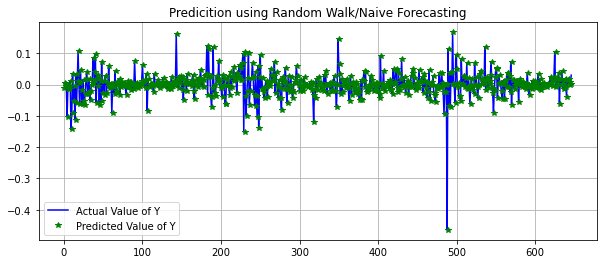

The RMSE is 5.9897%


In [95]:
# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
# not including the value of Y at t=0 as no predicted value exists at that time
plt.plot(Y_test[1:],"b-", label ="Actual Value of Y")
plt.plot(Y_predict_RandomWalk,"g*", label="Predicted Value of Y") 
plt.title("Predicition using Random Walk/Naive Forecasting")
plt.grid(True)
plt.legend()
plt.show()

# calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test[1:], Y_predict_RandomWalk))*100
print(rf"The RMSE is {rmse:2.4f}%")

# ARIMA

### Identifying hyperparameters

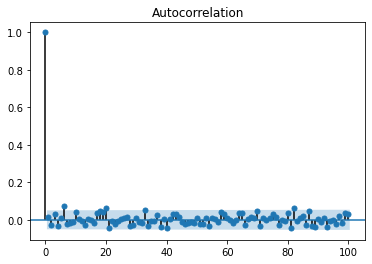

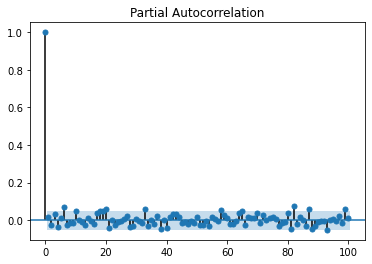

In [96]:
# Plotting the PACF and ACF to identify AR and MA lags (as per Box-Jenkins identification)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(Y_train, lags=100)
plot_pacf(Y_train,lags=100)
plt.show()

# For MA(q), only the first q autocorrelations are nonzero, so the ACF should cut off after lag q.
# For AR(p), the autocorrelations may decline gradually, but the PACF should cut off after lag p

### Building and training the model

In [97]:
#marking start time for model training
start_time = time.time()

#training the ARIMA model
ARIMA_model = ARIMA(endog = Y_train, order=(0,0,0)).fit()

#calculating time taken to train
print("--- %s seconds ---" % (time.time() - start_time))

#printing model summary statistics 
print(ARIMA_model.summary())

--- 0.011868953704833984 seconds ---
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1511
Model:                     ARMA(0, 0)   Log Likelihood                2767.278
Method:                           css   S.D. of innovations              0.039
Date:                Wed, 04 Nov 2020   AIC                          -5530.556
Time:                        15:48:55   BIC                          -5519.915
Sample:                             0   HQIC                         -5526.594
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.854      0.064      -0.000       0.004


### Testing the model using validation data

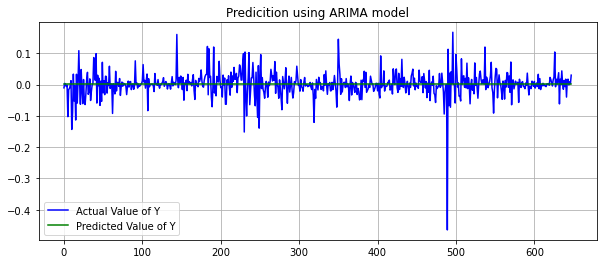

The RMSE is 4.0478%


In [98]:
#predicting using test data
forecast_length = len(Y_test)
ARIMA_forecast = ARIMA_model.forecast(forecast_length)

# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test,"b-", label ="Actual Value of Y")
plt.plot(ARIMA_forecast[0],"g-", label="Predicted Value of Y") 
plt.title("Predicition using ARIMA model")
plt.grid(True)
plt.legend()
plt.show()

# calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test, ARIMA_forecast[0]))*100
print(rf"The RMSE is {rmse:2.4f}%")

# ARMAX

### Building and Training the model

In [90]:
#marking start time for model training
start_time = time.time()

# fit model
# seasonal effects and Integrating is set to zero to convert SARIMAX into ARMAX
ARMAX = SARIMAX(Y_train, exog=X_train_fs, order=(0, 0, 0)).fit(disp=False)

#printing time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

#print model summary stats
print(ARMAX.summary())

# make prediction
Y_predict_ARMAX= ARMAX.predict(1,len(Y_test),exog=X_test_fs)


--- 0.9724199771881104 seconds ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1511
Model:                        SARIMAX   Log Likelihood                2766.720
Date:                Wed, 04 Nov 2020   AIC                          -5521.440
Time:                        15:48:11   BIC                          -5489.517
Sample:                             0   HQIC                         -5509.552
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0005      0.001     -0.396      0.692      -0.003       0.002
x2             0.0001      0.001      0.092      0.926      -0.002       0.002
x3            -0.

### Testing the model using validation data

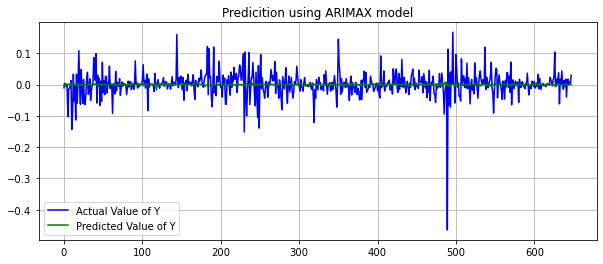

The RMSE is 4.0472%


In [91]:
# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test,"b-", label ="Actual Value of Y")
plt.plot(Y_predict_ARMAX,"g-", label="Predicted Value of Y") 
plt.title("Predicition using ARIMAX model")
plt.grid(True)
plt.legend()
plt.show()

# calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test, Y_predict_ARMAX))*100
print(rf"The RMSE is {rmse:2.4f}%")

# MACHINE LEARNING

## Support Vector Regressor

### Importing SVR model and setting seed for randomization to generate reproducible results

In [78]:
from sklearn.svm import SVR
seed(6)

### Building the model and tuning hyperparameters

In [60]:
# loading the model as SVR_Model with kernel = rbf
SVR_Model = SVR(kernel="rbf")

# fixing a range for evaluation of each parameter
c1= np.linspace(-0.0001,1000,5000)
gamma1=np.linspace(-0.0001,1000,5000)
epsilon1=np.linspace(-0.0001,1000,5000)

#creating a parameter grid
param_grid=dict(C=c1, gamma= gamma1, epsilon=epsilon1)

# conducting a random search and fitting the data to the model
randomsearch = RandomizedSearchCV(SVR_Model, param_grid, cv=5, scoring ='neg_mean_squared_error', random_state=6)
randomsearch.fit(X_train_fs, Y_train.ravel())  

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': array([-1.00000000e-04,  1.99940028e-01,  3.99980056e-01, ...,
        9.99599920e+02,  9.99799960e+02,  1.00000000e+03]),
                                        'epsilon': array([-1.00000000e-04,  1.99940028e-01,  3.99980056e-01, ...,
        9.99599920e+02,  9.99799960e+02,  1.00000000e+03]),
                                        'gamma': array([-1.00000000e-04,  1.99940028e-01,  3.99980056e-01, ...,
        9.99599920e+02,  9.99799960e+02,  1.00000000e+03])},
                   random_state=6, scoring='neg_mean_squared_error')

### Identifying chosen hyperparameters

In [61]:
print(rf'The chosen hyperparameters are {randomsearch.best_estimator_}')

The chosen hyperparameters are SVR(C=110.22195543108622, epsilon=371.8743120624125, gamma=76.01511064212842)


### Building and training the model with chosen hyperparameters

In [62]:
# marking start time for training 
start_time = time.time()

#loading the model with the chosen hyperparameters
SVR_Model_chosen = SVR(kernel="rbf", epsilon = 485.8971280256051, C = 371.8743120624125, gamma=76.01511064212842)

#training the model
SVR_Model_chosen.fit(X_train_fs, Y_train.ravel())

#calculating the time taken to train
print("--- %s seconds ---" % (time.time() - start_time))

# Training RMSE - calculate and print
Y_train_SVR = SVR_Model_chosen.predict(X_train_fs)
rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_SVR)))*100
print(rf"The RMSE is {rmse:2.4f}%")

--- 0.0018198490142822266 seconds ---
The RMSE is 3.9591%


### Testing the model using Validation Data

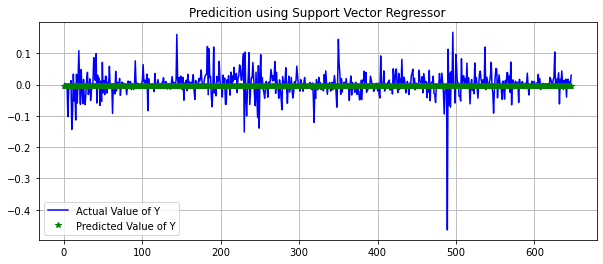

The RMSE is 4.1106%


In [102]:
# Use the model to make predicitions about test data
Y_predict_SVR = SVR_Model_chosen.predict(X_test_fs)

# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test,"b-", label ="Actual Value of Y")
plt.plot(Y_predict_SVR,"g*", label="Predicted Value of Y") 
plt.title("Predicition using Support Vector Regressor")
plt.grid(True)
plt.legend()
plt.show()

# calculating and printing root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_test, Y_predict_SVR)))*100
print(rf"The RMSE is {rmse:2.4f}%")

## Random Forest Regressor

### Importing Random Forest model and setting seed for randomization to generate reproducible results

In [66]:
from sklearn import ensemble
seed(7)

### Building the model and tuning hyperparameters

In [67]:
# loading the model as RFR (acronym for Random Forest Regressor)
RFR = ensemble.RandomForestRegressor()


# fixing a range for evaluation of each parameter
trees_range = np.arange(500,3000,250) 
depth_range = np.arange(0,21,1)
features_range = np.arange(0,6,1)
min_samples_leaf_range = np.arange(0,20,1)
min_samples_split_range = np.arange(0,50,2)


#creating a parameter grid
param_grid= dict(max_depth=depth_range,n_estimators=trees_range, max_features=features_range, min_samples_leaf=min_samples_leaf_range, min_samples_split= min_samples_split_range)


# conducting a random search and fitting the data to the model
randomsearch_RFR = RandomizedSearchCV(RFR, param_grid, cv=5, scoring ='neg_mean_squared_error', random_state=6, return_train_score=True)
randomsearch_RFR.fit(X_train_fs, Y_train.ravel())  



KeyboardInterrupt: 

### Identifying the chosen hyperparameters

In [ ]:
# printing the chosen hyperparameters
print(rf'The chosen hyperparameters are {randomsearch_RFR.best_estimator_}')

### Builiding and Training the model with chosen hyperparameters

In [75]:
# marking the start time for model training
start_time = time.time()

#loading the RFR model with the chosen hyperparameters
RFR_chosen = ensemble.RandomForestRegressor(n_estimators=2500, max_depth=6, max_features=2, min_samples_leaf=10, min_samples_split=38, random_state=6)

#training the model
RFR_chosen.fit(X_train_fs, Y_train.ravel())

#calculating and printing training time
print("--- %s seconds ---" % (time.time() - start_time))

# Training RMSE
Y_train_RFR = RFR_chosen.predict(X_train_fs)
rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_RFR)))*100
print(rf"The Training RMSE is {rmse:2.4f}%")


--- 5.577349901199341 seconds ---
The Training RMSE is 3.7027%


### Testing the model using Validation Data

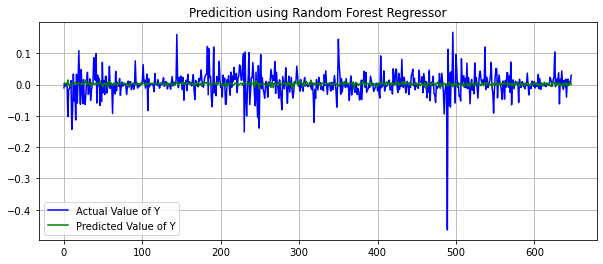

The RMSE is 4.0638%


In [101]:
# Use the model to make predicitions about testing data
Y_predict_RFR = RFR.predict(X_test_fs)

# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test,"b-", label ="Actual Value of Y")
plt.plot(Y_predict_RFR,"g-", label="Predicted Value of Y") 
plt.title("Predicition using Random Forest Regressor")
plt.grid(True)
plt.legend()
plt.show()

# calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test, Y_predict_RFR))*100
print(rf"The RMSE is {rmse:2.4f}%")

# Deep Learning

### Data Prep for DL

In [103]:
# changing the data into 3d arrays
from numpy import hstack
from numpy import array
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

DL_trainingdata= hstack((X_train_fs,Y_train))
DL_testingdata= hstack((X_test_fs,Y_test))

### Setting seeds to generate reproducible results

In [104]:
seed(6)
tensorflow.random.set_seed(6)

## DMLP

### Data Prep for MLP

In [105]:
# timestep is 1 in this model

X_train_DL, Y_train_DL = split_sequences(DL_trainingdata, 1)
X_test_DL, Y_test_DL = split_sequences(DL_testingdata, 1)

n_input = X_train_DL.shape[1] * X_train_DL.shape[2]

#reshaping into 2D array as per MLP requirements
X_train_MLP = X_train_DL.reshape((X_train_DL.shape[0], n_input))
X_test_MLP = X_test_DL.reshape((X_test_DL.shape[0], n_input))


print(X_train_MLP.shape, Y_train_DL.shape)
print(X_test_MLP.shape, Y_test_DL.shape)

(1511, 5) (1511,)
(648, 5) (648,)


### Building the DMLP Model

In [106]:
def DMLP_builder(activation1='relu', activation2='relu', dropoutrate=0.2,opt='adam',nn=15 ):
    DMLP = Sequential()
    #add model layers
    DMLP.add(Dense(nn, activation= activation1, input_dim=n_input))
    DMLP.add(Dropout(dropoutrate))
    DMLP.add(Dense(nn,activation=activation2))
    DMLP.add(Dropout(dropoutrate))
    DMLP.add(Dense(1))
    #compile model
    DMLP.compile(optimizer=opt, loss='mean_squared_error')
    return DMLP

### Using Random Search for hypertuning

In [380]:
#set early stopping monitor so the model stops training when loss wont reduce more
early_stopping_monitor = EarlyStopping(patience=5,  monitor='loss')

#setting a range for each hyperparameter
activation_range = ['relu','sigmoid','tanh']
dropout_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
opt_range = ['Adagrad', 'Adam', 'RMSProp']
epoch_range = [50,100,150,200,250,300,350,400,450,500]
batch_range = [8,16,32,64,128,256]
nn_range = [5,10,11,15,20,25]

# setting up a grid for hyperparameter values
param_grid1 = dict(activation1 = activation_range, activation2 = activation_range, dropoutrate= dropout_range, opt=opt_range, epochs=epoch_range, batch_size=batch_range, nn=nn_range)

# running a random search and fitting the data to the model
model_DMLP = KerasRegressor(build_fn = DMLP_builder)
randomsearch_DMLP = RandomizedSearchCV(model_DMLP, param_grid1, cv=5, random_state=6, verbose=0)
randomsearch_DMLP.fit(X_train_MLP, Y_train_DL,callbacks=early_stopping_monitor,verbose=0)  


19/19 [==============================] - 0s 884us/step - loss: 0.0017


RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f8afd96a880>,
                   param_distributions={'activation1': ['relu', 'sigmoid',
                                                        'tanh'],
                                        'activation2': ['relu', 'sigmoid',
                                                        'tanh'],
                                        'batch_size': [8, 16, 32, 64, 128, 256],
                                        'dropoutrate': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                        0.6, 0.7, 0.8, 0.9],
                                        'epochs': [50, 100, 150, 200, 250, 300,
                                                   350, 400, 450, 500],
                                        'nn': [5, 10, 11, 15, 20, 25],
                                        'opt': ['Adagrad', 'Adam', 'RMSProp']},
                   random_state=6)

### Identifying the best hyperparameters

In [107]:
print(randomsearch_DMLP.best_params_)

NameError: name 'randomsearch_DMLP' is not defined

### Building and training the model with chosen hyperparameters

In [108]:
seed(8)
tensorflow.random.set_seed(8)
from keras.callbacks import EarlyStopping

#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5)

#setting the start time for model training
start_time = time.time()

#builidng the model with the chosen hyperparameters
DMLP_chosen = DMLP_builder(activation1='tanh', activation2='relu', dropoutrate=0.5, opt='RMSProp', nn=25)
print(DMLP_chosen.summary())

#training model
DMLP_chosen.fit(X_train_MLP, Y_train_DL, validation_data = (X_test_MLP, Y_test_DL), epochs=250, batch_size=16, callbacks=[early_stopping_monitor], verbose=1)

#calculating and printing training time
print("--- %s seconds ---" % (time.time() - start_time))

# Training RMSE
Y_train_DMLP = DMLP_chosen.predict(X_train_MLP)
rmse = (np.sqrt(mean_squared_error(Y_train_DL, Y_train_DMLP)))*100
print(rf"The training RMSE is {rmse:2.4f}%")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                150       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/250
95/95 [==============================] - 0s 5ms/step - loss: 0.3180 - val_loss: 0.0332
Epoch 2/250
95/95 [=

### Testing the model using Validation Data

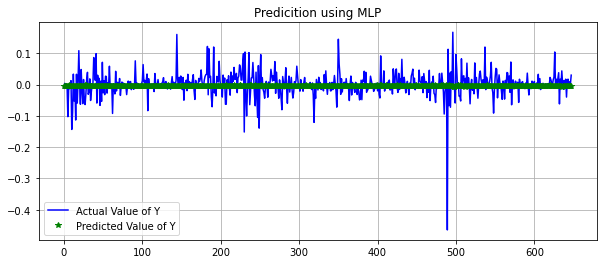

The RMSE is 4.0693%


In [109]:
# Use the model to make predicitions about unseen data
Y_predict_DMLP = DMLP_chosen.predict(X_test_MLP)

# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test_DL,"b-", label ="Actual Value of Y")
plt.plot(Y_predict_DMLP,"g*", label="Predicted Value of Y") 
plt.title("Predicition using MLP")
plt.grid(True)
plt.legend()
plt.show()

# calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test_DL, Y_predict_DMLP))*100
print(rf"The RMSE is {rmse:2.4f}%")

## RNN

### Data prep for RNN

In [110]:
#timestep = 30 (chosen bymanual search)

X_train_DL, Y_train_DL = split_sequences(DL_trainingdata, 30)
X_test_DL, Y_test_DL = split_sequences(DL_testingdata, 30)

print(X_train_DL.shape, Y_train_DL.shape)
print(X_test_DL.shape, Y_test_DL.shape)

(1482, 30, 5) (1482,)
(619, 30, 5) (619,)


### Building the RNN model

In [112]:
def RNN_builder(activation1='relu', activation2='relu', dropoutrate=0.2, opt='adam', nn=100 ):
    RNN_model = Sequential()
     #add model layers
    RNN_model.add(SimpleRNN(nn, activation=activation1,
                        input_shape=(X_train_DL.shape[1], X_train_DL.shape[2]),return_sequences=True))
    RNN_model.add(Dropout(dropoutrate))
    RNN_model.add(SimpleRNN(nn,activation=activation2))
    RNN_model.add(Dropout(dropoutrate))
    RNN_model.add(Dense(1)) # should be 1
    RNN_model.compile(loss='mean_squared_error', optimizer=opt)
    return RNN_model

### RandomSearch for hyperparameter tuning

In [526]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5,  monitor='loss')

#setting a range for each hyperparameter
activation_range = ['relu','sigmoid','tanh']
dropout_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
opt_range = ['Adagrad', 'Adam', 'RMSProp']
epoch_range = [50,100,150,200,250,300,350,400,450,500]
batch_range = [8,16,32,64,128,256]
nn_range = [10,20,30,40,50,60,70,80,90,100]


# setting up a grid for all hyperparameter values
param_grid1 = dict(activation1 = activation_range, activation2 = activation_range, dropoutrate= dropout_range, opt=opt_range, epochs=epoch_range, batch_size=batch_range, nn=nn_range)


#conducting random search and fitting the data
model_RNN = KerasRegressor(build_fn = RNN_builder)
randomsearch_RNN = RandomizedSearchCV(model_RNN, param_grid1, cv=5, random_state=6,verbose=0)
randomsearch_RNN.fit(X_train_DL, Y_train_DL,callbacks=early_stopping_monitor, verbose=0)  

3/3 [==============================] - 0s 5ms/step - loss: 0.0015
The chosen hyperparameters are {'opt': 'RMSProp', 'nn': 10, 'epochs': 100, 'dropoutrate': 0.8, 'batch_size': 128, 'activation2': 'tanh', 'activation1': 'sigmoid'}


### Identifying the best hyperparameters

In [ ]:
print(rf'The chosen hyperparameters are {randomsearch_RNN.best_params_}')

### Building and training the model with the chosen hyperparameters

In [114]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5,  monitor='loss')

# setting 
start_time = time.time()

RNN_chosen = RNN_builder(activation1='sigmoid', activation2='tanh', dropoutrate=0.8, opt='RMSProp', nn=10 )
print(RNN_chosen.summary())

#training model
RNN_chosen.fit(X_train_DL, Y_train_DL,epochs=100, batch_size=128, callbacks=[early_stopping_monitor], verbose=1)

print("--- %s seconds ---" % (time.time() - start_time))

#Training RMSE
Y_predict_train_RNN = RNN_chosen.predict(X_train_DL)
rmse = (np.sqrt(mean_squared_error(Y_train_DL.flatten(), Y_predict_train_RNN.flatten())))*100
print(rf"The training RMSE is {rmse:2.4f}%")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 30, 10)            160       
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 10)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 0s 15ms/step - loss: 3.8655
Epoch 2/100
12/12 [=================

### Testing the model with validation data

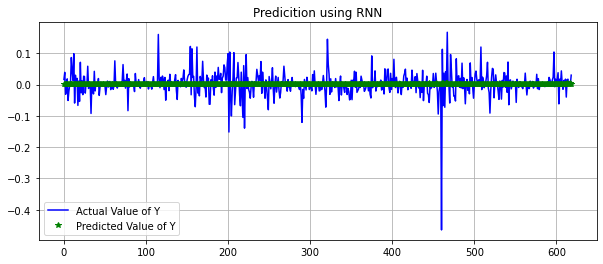

The RMSE is 3.9535%


In [115]:
# Use the model to make predicitions about unseen data
Y_predict_RNN = RNN_chosen.predict(X_test_DL)

# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test_DL.flatten(),"b-", label ="Actual Value of Y")
plt.plot(Y_predict_RNN.flatten(),"g*", label="Predicted Value of Y") 
plt.title("Predicition using RNN")
plt.grid(True)
plt.legend()
plt.show()

#calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test_DL.flatten(), Y_predict_RNN.flatten()))*100
print(rf"The RMSE is {rmse:2.4f}%")

### LSTM

### Data prep for LSTM

In [116]:
# Timestep = 50 (manual search)
X_train_DL, Y_train_DL = split_sequences(DL_trainingdata, 50)
X_test_DL, Y_test_DL = split_sequences(DL_testingdata, 50)

print(X_train_DL.shape, Y_train_DL.shape)
print(X_test_DL.shape, Y_test_DL.shape)

(1462, 50, 5) (1462,)
(599, 50, 5) (599,)


### Building LSTM model

In [117]:
def LSTM_builder(activation1='relu', activation2='relu', dropoutrate=0.4, opt='adam' ):
    LSTM_model = Sequential()
     #add model layers
    LSTM_model.add(LSTM(100, activation=activation1,
                        input_shape=(X_train_DL.shape[1], X_train_DL.shape[2]),return_sequences=True))
    LSTM_model.add(Dropout(dropoutrate))
    LSTM_model.add(LSTM(100,activation=activation2))
    LSTM_model.add(Dropout(dropoutrate))
    LSTM_model.add(Dense(1)) # should be 1
    LSTM_model.compile(loss='mean_squared_error', optimizer=opt)
    return LSTM_model

### Random Search for Hyperparameter Tuning

In [580]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5,  monitor='loss')

#setting a range for each hyperparameter
activation_range = ['relu','sigmoid','tanh']
dropout_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
opt_range = ['Adagrad', 'Adam', 'RMSProp']
epoch_range = [50,100,150,200,250,300,350,400,450,500]
batch_range = [8,16,32,64,128,256]

#setting up a grid for hyperparameters
param_grid1 = dict(activation1 = activation_range, activation2 = activation_range, 
                   dropoutrate= dropout_range, opt=opt_range, epochs=epoch_range, batch_size=batch_range)

#running random search and fitting model to data
model_LSTM = KerasRegressor(build_fn = LSTM_builder)
randomsearch_LSTM = RandomizedSearchCV(model_LSTM, param_grid1, cv=5, random_state=6, verbose=0)
randomsearch_LSTM.fit(X_train_DL, Y_train_DL,callbacks=early_stopping_monitor, verbose=0)  


KeyboardInterrupt: 

### Identifying the best hyperparameters

In [ ]:
print(rf'The chosen hyperparameters are {randomsearch_LSTM.best_params_}')

### Building and Training the model with the chosen hyperparameters

In [120]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5,  monitor='loss')


# marking the start time for model training
start_time = time.time()

#building the model with chosen hyperparameters
LSTM_chosen = LSTM_builder(activation1='tanh', activation2='relu', dropoutrate=0.7, opt='RMSProp' )
print(LSTM_chosen.summary())

#training model
LSTM_chosen.fit(X_train_DL, Y_train_DL,epochs=450, batch_size=16, callbacks=[early_stopping_monitor], verbose=1)

#calculating and printing the training time
print("--- %s seconds ---" % (time.time() - start_time))

#Training RMSE
Y_predict_train_LSTM = LSTM_chosen.predict(X_train_DL)
rmse = (np.sqrt(mean_squared_error(Y_train_DL.flatten(), Y_predict_train_LSTM.flatten())))*100
print(rf"The training RMSE is {rmse:2.4f}%")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           42400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/450
92/92 [==============================] - 5s 58ms/step - loss: 0.0028
Epoch 2/450
92/92 [=========

### Testing the model with validation data

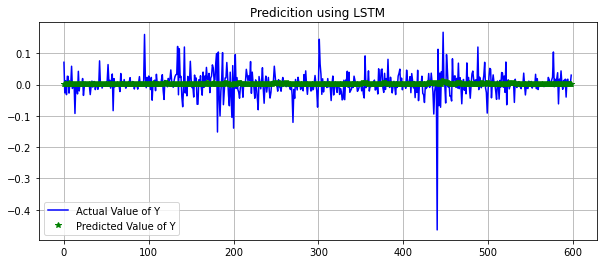

The RMSE is 3.9337%


In [121]:
# Use the model to make predicitions about unseen data
Y_predict_LSTM = LSTM_chosen.predict(X_test_DL)

# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test_DL.flatten(),"b-", label ="Actual Value of Y")
plt.plot(Y_predict_LSTM.flatten(),"g*", label="Predicted Value of Y") 
plt.title("Predicition using LSTM")
plt.grid(True)
plt.legend()
plt.show()

#calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test_DL.flatten(), Y_predict_LSTM.flatten()))*100
print(rf"The RMSE is {rmse:2.4f}%")

# Combination Forecast

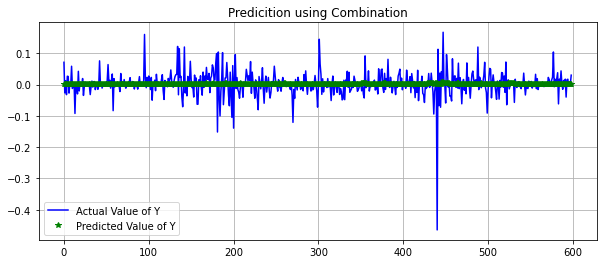

The RMSE is 3.9365%


In [122]:
# Generating an average of the forecast for LSTM and RNN
Y_predict_combination = (Y_predict_LSTM + Y_predict_RNN[20:])/2

# Generating a plot for actual and predicted values
plt.figure(figsize=[10,4])
plt.plot(Y_test_DL.flatten(),"b-", label ="Actual Value of Y")
plt.plot(Y_predict_combination.flatten(),"g*", label="Predicted Value of Y") 
plt.title("Predicition using Combination")
plt.grid(True)
plt.legend()
plt.show()

#calculating and printing root mean squared error
rmse = np.sqrt(mean_squared_error(Y_test_DL.flatten(), Y_predict_combination.flatten()))*100
print(rf"The RMSE is {rmse:2.4f}%")